## Import 

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms, models

import PIL.ImageOps
import requests
from PIL import Image

## Dataloader

In [4]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

transform_train = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      normalize,
                               ])


transform = transforms.Compose([transforms.Resize((224,224)),
                               transforms.ToTensor(),
                               normalize,
                               ])

training_dataset = datasets.ImageFolder('doraemon_shinchan/train', transform=transform_train)
validation_dataset = datasets.ImageFolder('doraemon_shinchan/val', transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=20, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset , batch_size=20, shuffle=False)

print("Number of training data: ", len(training_dataset))
print("Number of validation data: ", len(validation_dataset))

Number of training data:  200
Number of validation data:  100


## Display sample images

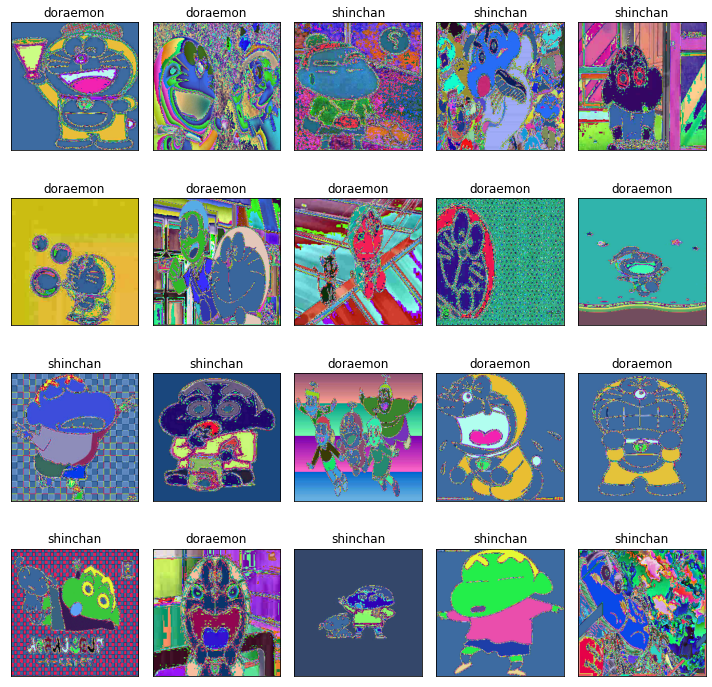

In [5]:
classes = ('doraemon', 'shinchan')   # doraemon folder loaded before shinchan.  doraemon=0  shinchan=1

dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(10, 10))

for idx in np.arange(20):
  ax = fig.add_subplot(4, 5, idx+1, xticks=[], yticks=[])
  plt.imshow(transforms.ToPILImage()(images[idx]))
  ax.set_title(classes[labels[idx].item()])

plt.tight_layout()
plt.show()


## Pretrained Model

In [6]:
# If the computer has cuda install, train on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
model = models.alexnet(pretrained=True)
print (model)

# Prevents weights and bias parameters get updated.
for param in model.features.parameters():
  param.requires_grad = False

# modify the last layer to 2 nodes
n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier[6] = last_layer
model.to(device)
print("last layer node: ", model.classifier[6].out_features)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to C:\Users\sheep/.cache\torch\checkpoints\alexnet-owt-4df8aa71.pth



AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)


## Training in action
Try to change learning rate and number of epochs

In [8]:
# Cross Entropy Loss with Adam Optimizer 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

epochs = 5

train_corrects_history = []
val_corrects_history = []

for e in range(epochs):

    train_corrects = 0.0 
    train_batch_loss = 0.0
    train_epoch_loss = 0.0
    val_corrects = 0.0
    val_epoch_loss = 0.0
    
    # loop through 60000 samples 100 at a time
    for batch_idx, data in enumerate(training_loader, start=1):
        inputs = data[0].to(device)
        labels = data[1].to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Return the index of the highest possibility
        # which are the predicted labels
        _, preds = torch.max(outputs, 1)
        train_batch_loss += loss.item()

        # sum up all the correct prediction
        # since (preds==labels).sum() is a tensor
        # we use item() to extract the number
        train_corrects += (preds == labels).sum().item()

        # print training loss every 2 mini-batch
        # train_batch_loss is the average loss for 100 mini-batch
        if batch_idx % 2 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
                   e + 1 , 
                   batch_idx * len(data[0]), 
                   len(training_loader.dataset),
                   100.* batch_idx * len(data[0]) / len(training_loader.dataset), 
                   train_batch_loss / 100 ))
            # accumulate loss for the epoch
            train_epoch_loss += train_batch_loss
            # reset the loss for every mini-batch
            train_batch_loss = 0.0
    else:
        # torch.no_grad deactivate the auograd engine, 
        # reduce memory usage and speed up computations
        with torch.no_grad():
            for val_data in validation_loader:
                val_inputs = val_data[0].to(device)
                val_labels = val_data[1].to(device)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)

                _, val_preds = torch.max(val_outputs, 1)
                val_epoch_loss += val_loss.item()
                val_corrects += (val_preds == val_labels).sum().item()


        # print result for every epoch 
        train_accuracy = 100. * train_corrects / len(training_loader.dataset)
        train_corrects_history.append(train_accuracy)
        # here batch_idx is the total number of mini-batch = 600
        train_epoch_loss /= batch_idx

        print('epoch :', (e+1))
        print('Train set: Accuracy: {}/{} ({:.0f}%), Average Loss: {:.6f}'.format(
                train_corrects, len(training_loader.dataset),
                train_accuracy, train_epoch_loss))


        
        val_accuracy = 100. * val_corrects / len(validation_loader.dataset)
        val_corrects_history.append(val_accuracy)
        val_epoch_loss /= batch_idx

        print('Validation set: Accuracy: {}/{} ({:.0f}%), Average Loss: {:.6f}'.format(
                val_corrects, len(validation_loader.dataset),
                val_accuracy, val_epoch_loss))

C:\Users\sheep\Miniconda3\envs\pytorch\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Epoch: 1 [40/200 (20%)] Loss: 0.013363
Train Epoch: 1 [80/200 (40%)] Loss: 0.005845
Train Epoch: 1 [120/200 (60%)] Loss: 0.003248
Train Epoch: 1 [160/200 (80%)] Loss: 0.002580
Train Epoch: 1 [200/200 (100%)] Loss: 0.001770
epoch : 1
Train set: Accuracy: 177.0/200 (88%), Average Loss: 0.268059
Validation set: Accuracy: 95.0/100 (95%), Average Loss: 0.071400
Train Epoch: 2 [40/200 (20%)] Loss: 0.001305
Train Epoch: 2 [80/200 (40%)] Loss: 0.000478
Train Epoch: 2 [120/200 (60%)] Loss: 0.000361
Train Epoch: 2 [160/200 (80%)] Loss: 0.000242
Train Epoch: 2 [200/200 (100%)] Loss: 0.000739
epoch : 2
Train set: Accuracy: 197.0/200 (98%), Average Loss: 0.031249
Validation set: Accuracy: 92.0/100 (92%), Average Loss: 0.102808
Train Epoch: 3 [40/200 (20%)] Loss: 0.000206
Train Epoch: 3 [80/200 (40%)] Loss: 0.000623
Train Epoch: 3 [120/200 (60%)] Loss: 0.000032
Train Epoch: 3 [160/200 (80%)] Loss: 0.000107
Train Epoch: 3 [200/200 (100%)] Loss: 0.000250
epoch : 3
Train set: Accuracy: 199.0/200 

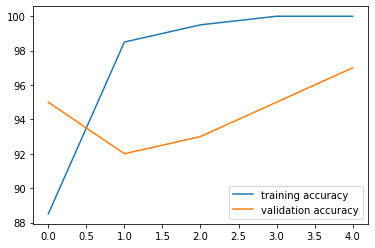

In [9]:
plt.plot(train_corrects_history, label='training accuracy')
plt.plot(val_corrects_history, label='validation accuracy')
plt.legend()
plt.show()

## Prediction vs. Grouund Truth

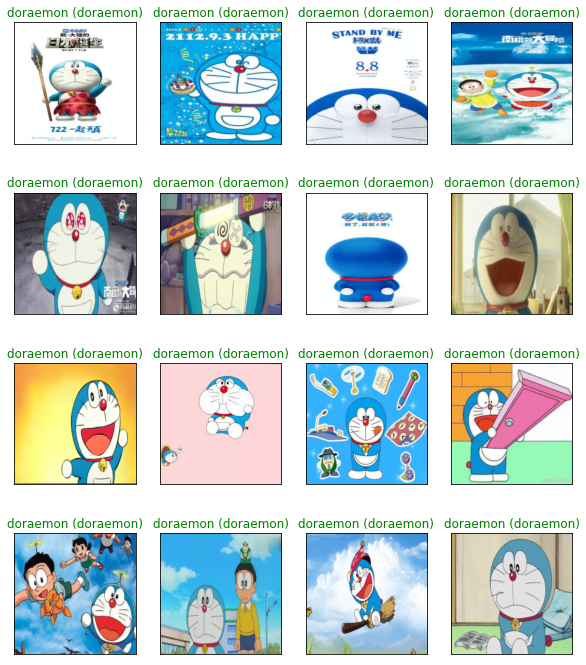

In [10]:
# Convert tensor image back to normal
def im_convert(tensor):
  image = tensor.cpu().numpy()
  image = image.transpose(1, 2, 0) # ToTensor Transpose image to C x H x W
                                   # we want to convert it back to H x W x C
                       
  image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
  image = image.clip(0, 1) # if an interval of [0, 1] is specified, 
                           #  values smaller than 0 become 0, 
                           #  and values larger than 1 become 1.
  return image

dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(10, 12))


for idx in np.arange(16):
  ax = fig.add_subplot(4, 4, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), 
                                str(classes[labels[idx].item()])), 
                                color=("green" if preds[idx]==labels[idx] else "red")
                                )
plt.show()

## Predict online images

our predicted result is  doraemon


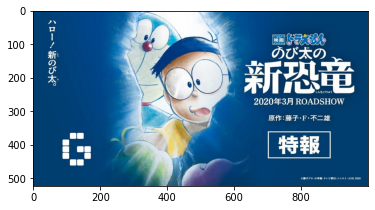

In [11]:
url = 'https://gamerbraves.sgp1.cdn.digitaloceanspaces.com/2019/11/doraemon-nobitas-new-dinosaur-edited.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

img = transform(img)
img = img.unsqueeze(0).to(device)
output = model(img)
_, pred = torch.max(output, 1)
print("our predicted result is ", classes[pred.item()])